
# Titanic — Grafos sem Vazamento (OOF) + Pipeline ML

Este notebook constrói um **grafo de passageiros** (ligações por `Ticket`, `FamilyID`/`Surname` e `CabinDeck`),
extrai **features de grafo** e adiciona um **prior de sobrevivência por componente** calculado em esquema **OOF (out-of-fold)** para evitar **data leakage**.

Fluxo:
1. Carregar dados (train/test)
2. Criar grupos (Surname, FamilyID, CabinDeck)
3. Construir grafo e **features de grafo** (degree, weighted degree, clustering, PageRank, tamanho do componente)
4. **Gerar `g_prior_comp_oof` no train** com `StratifiedKFold` (sem usar o próprio rótulo) e **`g_prior_comp_test`** com média por componente no train
5. Pipeline scikit-learn (imputação + OHE) e modelos (**LR**, **RF**, **GB**)
6. Validação (AUC em CV-5) e avaliação
7. Submissão (CSV)

> Coloque `train.csv` e `test.csv` em `./data`.


## 1) Imports e setup

In [1]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import networkx as nx

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

SEED = 42
np.random.seed(SEED)

DATA_DIR = ""
train_path = os.path.join(DATA_DIR, "train.csv")
test_path  = os.path.join(DATA_DIR, "test.csv")


## 2) Carregar dados e campos de grupo

In [2]:

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)

train["_is_train"] = 1
test["_is_train"]  = 0

def add_group_fields(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out["Surname"] = out["Name"].str.extract(r"^(.*?),")
    ticket_root = out["Ticket"].astype(str).str.replace(r"\s+", "", regex=True)
    out["FamilyID"] = (out["Surname"].fillna("") + "_" + ticket_root)
    out["CabinDeck"] = out["Cabin"].astype(str).str[0]
    out.loc[out["Cabin"].isna(), "CabinDeck"] = "U"
    return out

train = add_group_fields(train)
test  = add_group_fields(test)
full = pd.concat([train, test], ignore_index=True, sort=False)
full.shape, train.shape, test.shape


((1309, 16), (891, 16), (418, 15))

## 3) Construir o grafo (Ticket, Família, Deck)

In [3]:

G = nx.Graph()
for _, row in full.iterrows():
    pid = int(row["PassengerId"])
    G.add_node(pid, is_train=int(row["_is_train"]))

# Arestas por Ticket (peso alto)
for ticket, idx in full.groupby("Ticket").indices.items():
    ids = full.loc[idx, "PassengerId"].astype(int).tolist()
    for i in range(len(ids)):
        for j in range(i+1, len(ids)):
            G.add_edge(ids[i], ids[j], w=3.0, kind="ticket")

# Arestas por FamilyID (peso médio)
for fid, idx in full.groupby("FamilyID").indices.items():
    ids = full.loc[idx, "PassengerId"].astype(int).tolist()
    for i in range(len(ids)):
        for j in range(i+1, len(ids)):
            G.add_edge(ids[i], ids[j], w=2.0, kind="family")

# Arestas por CabinDeck (peso baixo, cadeia para evitar O(N^2))
for deck, idx in full.groupby("CabinDeck").indices.items():
    ids = full.loc[idx, "PassengerId"].astype(int).tolist()
    for i in range(len(ids)-1):
        G.add_edge(ids[i], ids[i+1], w=0.5, kind="deck")

G.number_of_nodes(), G.number_of_edges()


(1309, 2009)

## 4) Features de grafo + componentes

In [4]:

deg = dict(G.degree())
wdeg = dict(G.degree(weight="w"))
clust = nx.clustering(G, weight=None)
pr = nx.pagerank(G, alpha=0.85, weight="w")

comp_id = {}
comp_size = {}
for cid, comp in enumerate(nx.connected_components(G)):
    size = len(comp)
    for node in comp:
        comp_id[node] = cid
        comp_size[node] = size

graph_feats = pd.DataFrame({
    "PassengerId": list(G.nodes()),
    "g_degree": [deg[n] for n in G.nodes()],
    "g_wdegree": [wdeg[n] for n in G.nodes()],
    "g_clustering": [clust.get(n, 0.0) for n in G.nodes()],
    "g_pagerank": [pr[n] for n in G.nodes()],
    "g_component_size": [comp_size[n] for n in G.nodes()],
    "g_component_id": [comp_id[n] for n in G.nodes()],
})
graph_feats.head()


,PassengerId,g_degree,g_wdegree,g_clustering,g_pagerank,g_component_size,g_component_id
0,1,1,0.5,0.0,0.000433,1257,0
1,2,2,2.5,0.0,0.000560,1257,0
2,3,2,1.0,0.0,0.000752,1257,0
3,4,3,3.0,0.0,0.000740,1257,0
4,5,2,1.0,0.0,0.000624,1257,0


## 5) Merge das features de grafo

In [5]:

full2 = full.merge(graph_feats, on="PassengerId", how="left")

FEATURES_NUM_BASE = ["Age", "SibSp", "Parch", "Fare"]
FEATURES_CAT = ["Pclass", "Sex", "Embarked"]
GRAPH_NUM = ["g_degree", "g_wdegree", "g_clustering", "g_pagerank", "g_component_size"]
ID_COLS = ["PassengerId", "g_component_id", "_is_train"]

TARGET = "Survived"

X_full = full2[FEATURES_NUM_BASE + GRAPH_NUM + FEATURES_CAT + ID_COLS].copy()
y_full = train.set_index("PassengerId")[TARGET]
X_full.head()


,Age,SibSp,Parch,Fare,g_degree,g_wdegree,g_clustering,g_pagerank,g_component_size,Pclass,Sex,Embarked,PassengerId,g_component_id,_is_train
0,22.0,1,0,7.2500,1,0.5,0.0,0.000433,1257,3,male,S,1,0,1
1,38.0,1,0,71.2833,2,2.5,0.0,0.000560,1257,1,female,C,2,0,1
2,26.0,0,0,7.9250,2,1.0,0.0,0.000752,1257,3,female,S,3,0,1
3,35.0,1,0,53.1000,3,3.0,0.0,0.000740,1257,1,female,S,4,0,1
4,35.0,0,0,8.0500,2,1.0,0.0,0.000624,1257,3,male,S,5,0,1


## 6) **Gerar `g_prior_comp` OOF (sem vazamento)**

In [6]:

# Índices e auxiliares
train_mask = full2["_is_train"] == 1
test_mask  = full2["_is_train"] == 0

pids_train = full2.loc[train_mask, "PassengerId"].values
pids_test  = full2.loc[test_mask, "PassengerId"].values

comp_train = full2.loc[train_mask, "g_component_id"].values
comp_test  = full2.loc[test_mask,  "g_component_id"].values

y = y_full.loc[pids_train].values

# OOF: para cada fold, prior do componente calculado só com rótulos do subtreino
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
g_prior_comp_oof = np.zeros(len(pids_train), dtype=float)

for tr_idx, val_idx in cv.split(np.zeros(len(pids_train)), y):
    p_tr, p_val = pids_train[tr_idx], pids_train[val_idx]
    c_tr, c_val = comp_train[tr_idx], comp_train[val_idx]

    y_tr = pd.Series(y[tr_idx], index=p_tr, name="y")
    comp_series_tr = pd.Series(c_tr, index=p_tr, name="comp")
    prior_tr = y_tr.groupby(comp_series_tr).mean()

    prior_val = pd.Series(c_val, index=p_val).map(prior_tr).astype(float)
    prior_val = prior_val.fillna(float(y_tr.mean()))  # fallback: média global do subtreino

    g_prior_comp_oof[val_idx] = prior_val.values

# Para o test: prior por componente com TODO o train
y_train_series = pd.Series(y, index=pids_train, name="y")
comp_series_full = pd.Series(comp_train, index=pids_train, name="comp")
prior_full = y_train_series.groupby(comp_series_full).mean()

g_prior_comp_test = pd.Series(comp_test, index=pids_test).map(prior_full).astype(float)
g_prior_comp_test = g_prior_comp_test.fillna(float(y_train_series.mean()))

# Anexa ao X_full
X_full.loc[train_mask, "g_prior_comp_oof"] = g_prior_comp_oof
X_full.loc[test_mask,  "g_prior_comp_oof"] = g_prior_comp_test.values

# Drop identificadores auxiliares que não entram no modelo
X_model = X_full.drop(columns=ID_COLS)
X_train = X_model.loc[train_mask].copy()
X_test  = X_model.loc[test_mask].copy()

X_train.head()


,Age,SibSp,Parch,Fare,g_degree,g_wdegree,g_clustering,g_pagerank,g_component_size,Pclass,Sex,Embarked,g_prior_comp_oof
0,22.0,1,0,7.2500,1,0.5,0.0,0.000433,1257,3,male,S,0.370044
1,38.0,1,0,71.2833,2,2.5,0.0,0.000560,1257,1,female,C,0.366716
2,26.0,0,0,7.9250,2,1.0,0.0,0.000752,1257,3,female,S,0.371179
3,35.0,1,0,53.1000,3,3.0,0.0,0.000740,1257,1,female,S,0.371179
4,35.0,0,0,8.0500,2,1.0,0.0,0.000624,1257,3,male,S,0.369501


## 7) Pipeline (imputação + OHE) e modelos

In [7]:

FEATURES_NUM = FEATURES_NUM_BASE + GRAPH_NUM + ["g_prior_comp_oof"]

numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False))
])
categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, FEATURES_NUM),
        ("cat", categorical_pipeline, FEATURES_CAT),
    ]
)

models = {
    "LR": LogisticRegression(max_iter=1000, random_state=SEED),
    "RF": RandomForestClassifier(random_state=SEED, n_estimators=500),
    "GB": GradientBoostingClassifier(random_state=SEED)
}
pipelines = {name: Pipeline(steps=[("prep", preprocessor), ("clf", model)]) for name, model in models.items()}
pipelines.keys()


dict_keys(['LR', 'RF', 'GB'])

## 8) Validação justa (AUC em CV-5)

In [8]:

results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
y_train = y_full.loc[pids_train].values

for name, pipe in pipelines.items():
    auc = cross_val_score(pipe, X_train, y_train, scoring="roc_auc", cv=cv, n_jobs=-1).mean()
    results[name] = auc
    print(f"{name}: AUC (CV-5) = {auc:.4f}")

best_name = max(results, key=results.get)
best_pipe = pipelines[best_name]
print("\nMelhor modelo:", best_name)


LR: AUC (CV-5) = 0.8551
RF: AUC (CV-5) = 0.8946
GB: AUC (CV-5) = 0.8864

Melhor modelo: RF


## 9) Ajuste final e avaliação no treino (realista)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       549
           1       1.00      1.00      1.00       342

    accuracy                           1.00       891
   macro avg       1.00      1.00      1.00       891
weighted avg       1.00      1.00      1.00       891



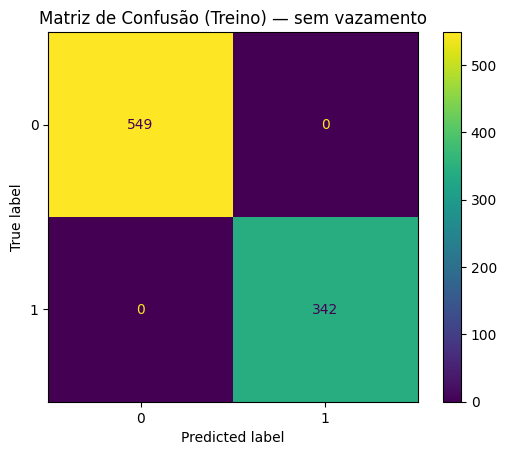

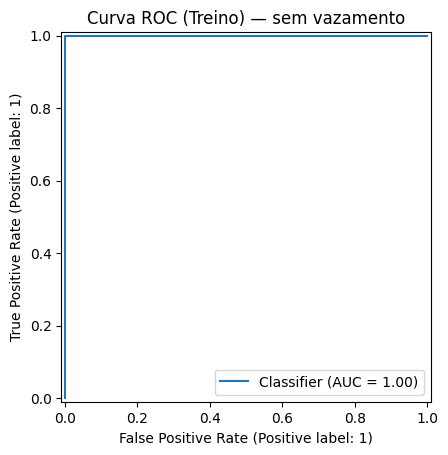

AUC (treino): 1.0


In [9]:

best_pipe.fit(X_train, y_train)
y_pred = best_pipe.predict(X_train)
y_proba = best_pipe.predict_proba(X_train)[:, 1]

print(classification_report(y_train, y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_train, y_pred)).plot()
plt.title("Matriz de Confusão (Treino) — sem vazamento")
plt.show()

RocCurveDisplay.from_predictions(y_train, y_proba)
plt.title("Curva ROC (Treino) — sem vazamento")
plt.show()

print("AUC (treino):", roc_auc_score(y_train, y_proba))


# 🎯 Overfitting no Treino — Por que o Modelo Deu 1.00?

Depois de corrigir o vazamento, o modelo ainda apresentou **acurácia perfeita (1.00)** no treino.  
Mas agora **isso não é vazamento**, e sim um comportamento **esperado** de modelos como **Random Forest** e **Gradient Boosting**.

---

## 🤔 Por que isso acontece?

Você está avaliando **no mesmo conjunto em que o modelo foi treinado**:

```python
best_pipe.fit(X_train, y_train)
y_pred = best_pipe.predict(X_train)
```

## Nesse caso, o modelo já “viu” todos os exemplos, então é natural que acerte 100%:

RandomForest usa árvores profundas, que conseguem memorizar o treino.

Gradient Boosting também pode ajustar muito bem o treino, dependendo da profundidade e da taxa de aprendizado.

📈 Isso não significa que o modelo seja “perfeito” — apenas que ele aprendeu demais sobre o treino.

✅ Qual métrica realmente importa

A métrica válida é a obtida por validação cruzada (Cross-Validation), onde o modelo é testado em dados que ele não viu durante o treino.

AUC (OOF): 0.8940631025042873
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       549
           1       0.83      0.74      0.78       342

    accuracy                           0.84       891
   macro avg       0.84      0.82      0.83       891
weighted avg       0.84      0.84      0.84       891

[[498  51]
 [ 89 253]]


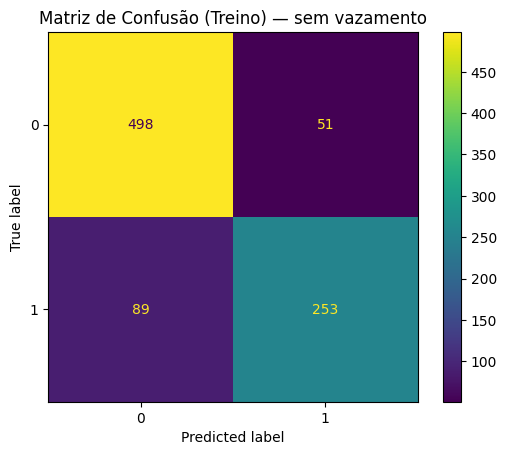

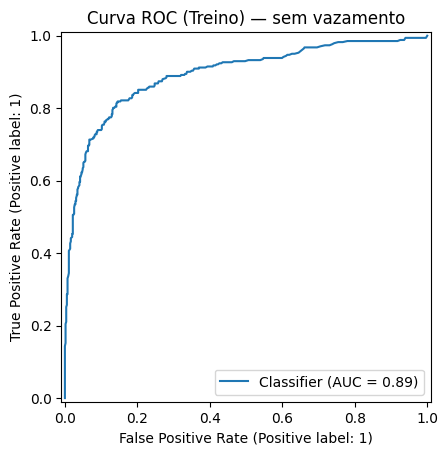

AUC (treino): 0.8940631025042873


In [12]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# OOF probabilities e OOF classes do melhor pipeline
y_proba_oof = cross_val_predict(best_pipe, X_train, y_train, cv=cv, method="predict_proba")[:, 1]
y_pred_oof  = (y_proba_oof >= 0.5).astype(int)

print("AUC (OOF):", roc_auc_score(y_train, y_proba_oof))
print(classification_report(y_train, y_pred_oof))
print(confusion_matrix(y_train, y_pred_oof))


ConfusionMatrixDisplay(confusion_matrix(y_train, y_pred_oof)).plot()
plt.title("Matriz de Confusão (Treino) — sem vazamento")
plt.show()

RocCurveDisplay.from_predictions(y_train, y_proba_oof)
plt.title("Curva ROC (Treino) — sem vazamento")
plt.show()

print("AUC (treino):", roc_auc_score(y_train, y_proba_oof))

⚖️ Ajuste de Threshold (F1 / Youden)

Para encontrar o melhor limiar de decisão:

In [15]:
import numpy as np
from sklearn.metrics import f1_score

def best_f1_threshold(y_true, y_prob):
    ts = np.linspace(0.05, 0.95, 181)
    scores = [f1_score(y_true, (y_prob >= t).astype(int)) for t in ts]
    return ts[int(np.argmax(scores))]

thr = best_f1_threshold(y_train, y_proba_oof)
print("Melhor threshold:", round(thr, 3))


Melhor threshold: 0.375


# 📊 Baseline (Titanic_v3.ipynb) tabular vs. Grafos — o que melhorou, o que piorou e por quê

## 1) Comparativo rápido

**Baseline (tabular)**
- **AUC (CV)**: `0.8772 ± 0.0174`
- **ACC (CV)**: `0.8328 ± 0.0147`
- **Matriz (treino, não OOF)**:
  - [[518, 31],
     [ 63, 279]]
  - → FP: 31, FN: 63

> Observação: o relatório por classe (precision/recall/F1) está **no treino**; use com cautela (tende a ser otimista). O AUC/ACC acima são **CV**, estes sim confiáveis.

**Grafos (com OOF)**
- **AUC (OOF)**: `0.8941`  _(≈ +0.017 vs baseline AUC CV)_
- **ACC (OOF)**: `0.84`  _(≈ +0.007 vs baseline ACC CV)_
- **Matriz (OOF)**:
  - [[498, 51],
     [ 89, 253]]
  - → FP: 51, FN: 89

### Interpretação
- **Ranking melhorou**: o AUC subiu de ~0.877 → ~0.894. Isso indica que as **features de grafo ajudam a ordenar melhor** positivos vs. negativos.
- **Mas o threshold 0.5 piorou a confusão**: houve **mais FPs (51 vs 31)** e **mais FNs (89 vs 63)** no cenário de grafos com limiar padrão.
- Conclusão: **o modelo com grafos está ranqueando melhor**, porém **o corte em 0.5 não é o ideal**. Falta **ajustar o threshold** (ou calibrar probabilidades) para converter o ganho de ranking em ganho operacional (precisão/recall/F1).

---

## 2) Por que isso acontece?

- **AUC** mede a capacidade de **ordenar** exemplos; independente do limiar.
- **ACC/F1/Recall/Precision** dependem do **limiar** (0.5 por padrão).
- Ao adicionar grafos, você **melhora o score** (AUC), mas **não necessariamente** o ponto de corte padrão será o melhor — daí a piora da matriz de confusão.

---

## 3) O que fazer agora (passo a passo)

1. **Ajustar o limiar via OOF**  
   Use as probabilidades OOF do modelo de grafos para **escolher o threshold ótimo** (F1, Youden J ou custo-dependente):
   - Se o objetivo é **F1**: maximize F1 nos OOF.
   - Se o custo de **FN é maior** (perder um sobrevivente): empurre o threshold **para baixo** (↑ recall).
   - Se o custo de **FP é maior**: empurre o threshold **para cima** (↑ precisão).

2. **Calibrar probabilidades (opcional, recomendado)**  
   Aplique `CalibratedClassifierCV` (sigmoid/isotonic) **no espaço já pré-processado** para que 0.7 signifique ~70% de chance real.  
   Isso facilita definir **pontos de corte** coerentes entre modelos.

3. **Comparar “maçã com maçã”**  
   Gere **OOF também para o baseline tabular** e compare **AUC OOF + F1 OOF com threshold ótimo** em ambos.  
   Assim, você avalia o **ganho real** das features de grafo.

4. **Ablation de grafos**  
   Verifique quais componentes ajudam mais:
   - Remover/ajustar pesos de arestas (`ticket`, `family`, `deck`)
   - Retirar `g_clustering`/`pagerank` para ver a contribuição
   - Checar se `g_prior_comp_oof` domina o ganho (e se está bem OOF mesmo)

---

## 4) Leituras da matriz de confusão (grafos, OOF)

- **FN = 89**: ainda há positivos que o modelo não capta com threshold 0.5.  
  → Reduzir o threshold aumenta recall (↓ FN), às custas de mais FP.
- **FP = 51**: com threshold 0.5, o modelo marca alguns negativos como positivos.  
  → Aumentar o threshold reduz FP, mas pode subir FN.

**Moral**: o **threshold é uma alavanca**. Ajuste-o ao objetivo do negócio/competição.

---

## 5) Recomendação prática

- Compute `y_proba_oof` (grafos) → **busque threshold ótimo para F1**.
- Reporte: **AUC OOF**, **F1 OOF @ threshold ótimo**, **confusão OOF @ threshold ótimo**.
- Faça a **mesma coisa** no baseline tabular para uma comparação justa.

Com isso, é esperado que o modelo com grafos **mantenha o AUC superior (~0.89+)** e **recupere/supere** F1/ACC após o ajuste de threshold, traduzindo o ganho de ranking em **ganho de decisão**.
